# 30: Freezing Weights (Transfer Learning Basics)

### 🎯 Objective
This notebook demonstrates how to **freeze** specific weights in a neural network so they are not updated during training. We will train a model on MNIST, pause to freeze the weights (but not biases), and observe how learning essentially stops for those components. This is the core mechanism behind **Transfer Learning**.

### 📚 Key Concepts
- **`requires_grad`:** The boolean attribute in PyTorch tensors that determines if gradients should be calculated. Setting this to `False` effectively freezes the parameter.
- **Freezing:** Locking parameters at their current value.
- **Impact:** When weights are frozen, the loss curve usually flattens because the model loses the ability to adapt those parts of its brain.

In [1]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-2580320524.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## 1. Import and Process Data (MNIST)
Standard setup: Load, Normalize, Split, Batch.

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [3]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

## 2. Define the Model
Standard ANN architecture.

In [10]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer

## 3. Train Function
We modify the training loop slightly to accommodate the experiment.

In [11]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 100
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):



    
    # NEW: switch off learning in all-but-output layers during first 1/2 of training
    if epochi<(numepochs/2):
      for p in net.named_parameters():
        if 'output' not in p[0]:
          p[1].requires_grad = False
    else:
      for p in net.named_parameters():
        p[1].requires_grad = True
    
    



    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

## 4. Let's see it in action!

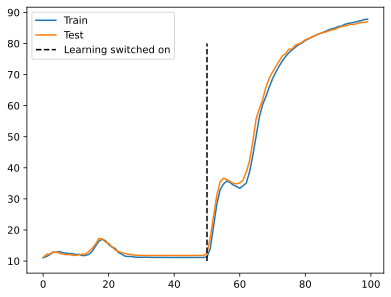

In [12]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net = function2trainTheModel(net,lossfun,optimizer)

plt.plot(trainAcc,label='Train')
plt.plot(testAcc,label='Test')
plt.plot([len(trainAcc)/2, len(trainAcc)/2],[10,80],'k--',label='Learning switched on')
plt.legend()
plt.show()